# Reproducing Balaban Exp3 CDA Study (2019)
## Reproducing Results from Paper (raw - no cleaning)

In [1]:
import numpy as np
import pandas as pd
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Balaban-2019/')
from events import get_specific_events, checksum_epochs

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [3]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
triggers = dict();

triggers['CF_NoFrame'] = [21] 
triggers['Sep_NoFrame'] = [22]
triggers['CF_Frame'] = [23]
triggers['Sep_Frame'] = [24]
triggers['left'] = [31]
triggers['right'] = [32]

triggers['good'] = [50,60]   # YR: Why 2 triggers for good and 2 triggers for bad?!
triggers['bad'] = [5,6]

# Labels
conds = ['CF_NoFrame', 'Sep_NoFrame', 'CF_Frame', 'Sep_Frame']
sides = ['left', 'right']
perfs = ['good', 'bad']

# # CDA Channels
chan_right = ['P8', 'PO8', 'PO4']
chan_left = ['P7', 'PO7', 'PO3']

# # CDA main variable!
cda_dict = dict()

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
folderpath = '/Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp3_EEG/'
#folderpath = 'D:\\CLNT\\Data\\Open Datasets\\Balaban 2019\\Data\\Exp3_EEG\\'
#filepath = folderpath + '536.bdf'
foldersep = '/'

for filepath in glob.iglob(folderpath + '*.bdf'):
    file_name = filepath[filepath.rfind(foldersep)+1:]
    print('Processing: ' + file_name + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)
    
    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    raw = raw.drop_channels(ch_names=['EXG3','EXG4','EXG5','EXG6', 'EXG7','EXG8',])
    raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])
    raw = raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc'})

    # Set Electrodes Locations
    #montage = mne.channels.make_standard_montage('biosemi32')
    #raw.set_montage(montage)

    preproc = raw

    # Resample
    #preproc = preproc.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 30., fir_design='firwin', skip_by_annotation='edge')

    events = find_events(preproc)
    #preproc.plot(events=events, block=True, lowpass=40)
    
    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    # Get events based on conditions, sides (L/R) and performances
    # Code available in events.py
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epoch_length = 1.7
    epoch_tmin = -0.2
    baseline_corr = (-0.2, 0)

    print("====================== EPOCHING ======================")
    print("tmin:{}, tmax:{}, baseline={}".format(epoch_tmin, epoch_length, baseline_corr))
    
    epochs_dict = dict()
    for cur_cond in specific_events.keys():
        epochs_dict[cur_cond] = dict()

        for cur_side in specific_events[cur_cond].keys():
            epochs_dict[cur_cond][cur_side] = dict()

            for cur_perf in specific_events[cur_cond][cur_side].keys():
                print('---------- {}-{}-{} -------------'.format(cur_cond, cur_side, cur_perf))

                if(len(specific_events[cur_cond][cur_side][cur_perf]) > 0):
                    epochs_dict[cur_cond][cur_side][cur_perf] = Epochs(preproc, specific_events[cur_cond][cur_side][cur_perf], tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge')
                else:
                    epochs_dict[cur_cond][cur_side][cur_perf] = None
    print("====================== /EPOCHING ======================")

    # ------------------------
    # Checksum Epochs!
    # ------------------------
    #checksum_epochs(epochs, events, specific_events)


    # ------------------------
    # CDA - GROUP
    # ------------------------
    cda_dict[file_name] = dict()

    for cur_cond in conds:
        cda_dict[file_name][cur_cond] = dict()

        for cur_side in sides:
            cda_dict[file_name][cur_cond][cur_side] = dict()

            for cur_perf in perfs:
                if epochs_dict[cur_cond][cur_side][cur_perf] is not None:
                    epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_right)
                    epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_left)

                    evoked_right = epochs_right.average()
                    evoked_left = epochs_left.average()

                    left = evoked_left.data.mean(0)
                    right = evoked_right.data.mean(0)

                    if cur_side == 'left':
                        cda_dict[file_name][cur_cond][cur_side][cur_perf] = left - right
                    else:
                        cda_dict[file_name][cur_cond][cur_side][cur_perf] = right - left

        #cda_dict[key_combined] = (cda_dict[key_left] + cda_dict[key_right]) / 2

# Add time points to CDA for later use.
cda_dict['times'] = epochs_dict[conds[0]]['left']['good'].times

Processing: 649.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp3_EEG/649.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1107199  =      0.000 ...  4324.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_e

0 bad epochs dropped
---------- CF_NoFrame-right-good -------------
Not setting metadata
Not setting metadata
82 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 82 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-right-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-left-good -------------
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 89 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-left-bad -------------
Not setting metadata
Not setting metadata
27 matching events found
Applying baseline correction (mode: mean)
0 projection items activate

Not setting metadata
99 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 99 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-right-bad -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-left-good -------------
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 89 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-left-bad -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 487 original time points ...
0 bad epochs dropped
---------- S

- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
5560 events found
Event IDs: [    5     6    21    22    23    24    31    32    41    42    50    60
    80    99   100   101   102   103   104   105   106   107   108   109
   110   111   112   113   114   131   132   133   134   135   136   137
   138   139   140   141   142   143   144   145   146   147   148   149
   150   151   152   153   154   155   156   157   158   159   160   161
   162   163   164   165   166   167   168   169   170   171   172   173
   174   175   176   177   178   179   180   181   182   183   184   185
   186   187   188   189   190 65635 65790]
====================== EPOCHING ======================
t

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 81 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-left-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 18 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-right-good -------------
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 78 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-right-bad -------------
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 26 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-left-good -------------
Not se

0 bad epochs dropped
---------- Sep_Frame-left-bad -------------
Not setting metadata
Not setting metadata
20 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 20 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-right-good -------------
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 101 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-right-bad -------------
Not setting metadata
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 10 events and 487 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Processing: 641.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp3_EEG/641.bdf..

====================== EPOCHING ======================
tmin:-0.2, tmax:1.7, baseline=(-0.2, 0)
---------- CF_NoFrame-left-good -------------
Not setting metadata
Not setting metadata
113 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 113 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-left-bad -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-right-good -------------
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 97 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-right-bad -------------
Not setting metadata
Not setting metadata
10 matching events fou

0 bad epochs dropped
---------- CF_Frame-left-good -------------
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 91 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-left-bad -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-right-good -------------
Not setting metadata
Not setting metadata
78 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 78 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-right-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading 

====================== /EPOCHING ======================
Processing: 644.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Balaban 2019/Data/Exp3_EEG/644.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1008127  =      0.000 ...  3937.996 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a n

19 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 19 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-right-good -------------
Not setting metadata
Not setting metadata
71 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 71 events and 487 original time points ...
0 bad epochs dropped
---------- CF_NoFrame-right-bad -------------
Not setting metadata
Not setting metadata
22 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 22 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-left-good -------------
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_NoFrame-lef

Loading data for 20 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-right-good -------------
Not setting metadata
Not setting metadata
98 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 98 events and 487 original time points ...
0 bad epochs dropped
---------- CF_Frame-right-bad -------------
Not setting metadata
Not setting metadata
17 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 17 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-left-good -------------
Not setting metadata
Not setting metadata
92 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 92 events and 487 original time points ...
0 bad epochs dropped
---------- Sep_Frame-left-bad -------------
Not setting metadata
Not setting metadata
18 matching events found
Applying baseline


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8449 samples (33.004 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
5548 events found
Event IDs: [    5     6    21    22    23    24    31    32    41    42    50    60
    80    99   100   101   102   103   104   105   106   107   108   109
   110   111   112   113   114   131   132   133   134   135   136   137
   138   139   140   141   142   143   144   145   146   147   148   149
   150   151   152   153   154   155   156   157   158   159   160   161
   162   163   16

## 2. Save CDA Data

In [4]:
# ------------------------
# Save the whole CDA dict.
# ------------------------
with open("cda_balaban2019_exp3_raw.pkl","wb") as f:
    pickle.dump(cda_dict, f)

## 3. Load CDA Data

In [5]:
with open("cda_balaban2019_exp3_raw.pkl","rb") as f:
    cda_dict = pickle.load(f)

times = cda_dict['times']
del cda_dict['times']

len(cda_dict)

16

## 4. Plot CDA Data - Grand CDA Average

In [6]:
cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():
        if len(cda_dict[f][cond]['left']['good']) > 0:
            cda_dict_cur = (cda_dict[f][cond]['left']['good'] + cda_dict[f][cond]['right']['good'])/2
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))

cda_all

## ====== Manual Cleanup ========
# Anything specific required for Balaban 2019?

{'CF_NoFrame': array([[-3.43223036e-08, -2.90573828e-08, -4.06287974e-08, ...,
          1.15912463e-06,  9.92026928e-07,  8.45838062e-07],
        [-5.13583915e-07, -3.12678436e-09,  5.04836072e-07, ...,
          2.48990740e-07,  2.71138100e-07,  2.75092743e-07],
        [ 3.66981974e-07,  3.68407601e-07,  4.39946723e-07, ...,
          2.02786862e-07,  1.87331848e-07,  1.67965510e-07],
        ...,
        [-6.04432036e-08, -1.42805390e-07, -1.98512868e-07, ...,
         -6.37681826e-07, -6.37440444e-07, -5.75259788e-07],
        [ 3.38746935e-07,  2.28507970e-07,  1.10001019e-07, ...,
          2.59031751e-07,  3.25610208e-07,  3.41479440e-07],
        [-3.93382600e-07, -2.11926691e-07,  2.80126262e-08, ...,
          5.51389165e-07,  5.37897325e-07,  5.55464255e-07]]),
 'Sep_NoFrame': array([[-7.49164841e-08,  5.46001752e-09,  1.17630767e-07, ...,
          4.15249850e-07,  3.05386550e-07,  1.70156236e-07],
        [ 1.07450697e-06,  1.11335184e-06,  1.05053034e-06, ...,
         

## Final CDA figure from Balaban 2019

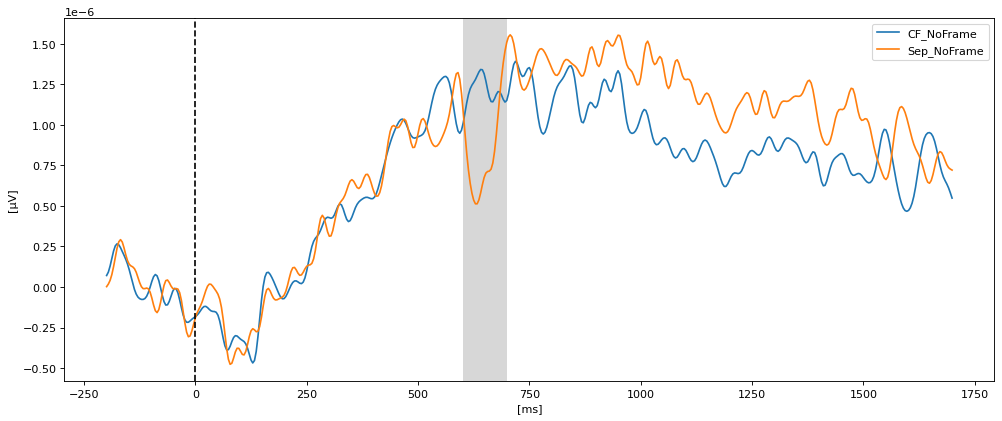

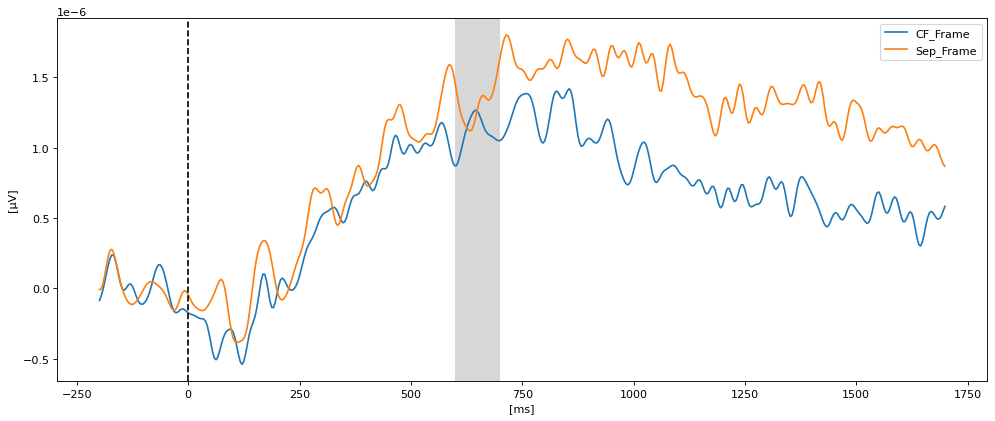

In [7]:
plt.figure(figsize=(15, 6), dpi=80)
plt.plot((times * 1000), cda_all['CF_NoFrame'].mean(0), label='CF_NoFrame')
plt.plot((times * 1000), cda_all['Sep_NoFrame'].mean(0), label='Sep_NoFrame')

plt.axvline(x=0, color='k', linestyle='--')
plt.axvspan(600, 700, alpha=0.9, facecolor='lightgray')
#plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()
#plt.savefig("Balaban-2019-Exp3-CDA1-reprod.jpg", dpi=300)

# ----

plt.figure(figsize=(15, 6), dpi=80)
plt.plot((times * 1000), cda_all['CF_Frame'].mean(0), label='CF_Frame')
plt.plot((times * 1000), cda_all['Sep_Frame'].mean(0), label='Sep_Frame')

plt.axvline(x=0, color='k', linestyle='--')
plt.axvspan(600, 700, alpha=0.9, facecolor='lightgray')
#plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
plt.show()
#plt.savefig("Balaban-2019-Exp3-CDA2-reprod.jpg", dpi=300)